In [1]:
from openai import OpenAI
import pandas as pd
import json
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

In [4]:
ems = """
admiration
amusement
anger
annoyance
approval
caring
confusion
curiosity
desire
disappointment
disapproval
disgust
embarrassment
excitement
fear
gratitude
grief
joy
love
nervousness
optimism
pride
realization
relief
remorse
sadness
surprise
neutral
    """

In [5]:
def emotions_to_categorical(df):
    res = []

    for i in df['emotions']:
        tmp = [0 for _ in range(28)]
        for j in i:
            tmp[j] = 1
        res.append(tmp)
    tmp_df = pd.DataFrame(res, columns=ems.split())
    
    return tmp_df

In [6]:
def emotions_to_ekman(df):
    # anger disgust fear joy sadness surprise neutral
    ekman = [3, 3, 0, 0, 3, 3, 5, 5, 3, 4, 0, 1, 4, 3, 2, 3, 4, 3, 3, 2, 3, 3, 5, 3, 4, 4, 5, 6]
    res = []

    for i in df:
        tmp = [0, 0, 0, 0, 0, 0, 0]
        for j in range(len(i)):
            if i[j] == 1:
                tmp[ekman[j]] = 1
        res.append(tmp)
    tmp_df = pd.DataFrame(res, columns=['angry', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'])
    
    return tmp_df

In [7]:
def data_init(path = "../data/dev.tsv"):
    df = pd.read_csv(path, sep="\t", encoding = "utf-8", header=None)
    df.columns = ['text', 'emotions', 'id']
    df['emotions'] = list(map(lambda s : list(map(int, s.split(','))), df['emotions']))
    df = pd.concat([df, emotions_to_categorical(df)], axis=1)
    df = df.drop(columns=['emotions', 'id'])
    df['text'] = list(map(lambda s : s.replace('\\', '\\\\').replace('"', '\\"'), list(df['text']))) 
    return df.iloc[:2500, :]

In [8]:
def evaluation(original_df, emotion_res):
    emotions_list = ems.split()
    df = original_df
    predicted_df = pd.DataFrame(data = [[0 for _ in range(28)] for _ in range(len(df))], columns=emotions_list)
    for i in range(len(emotion_res)):
        for j in emotion_res[i]:
            if j in emotions_list:
                predicted_df.loc[i, j] = 1
    predicted = predicted_df.to_numpy()
    original = df.iloc[:,1:].to_numpy()
    
    
    accuracy = accuracy_score(original, predicted)
    
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        original, predicted, average='micro'
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        original, predicted, average='macro'
    )
    
    precision_per_label, recall_per_label, f1_per_label, _ = precision_recall_fscore_support(
        original, predicted, average=None
    )

    precision_macro_std = np.std(precision_per_label)
    recall_macro_std = np.std(recall_per_label)
    f1_macro_std = np.std(f1_per_label)

    print("--- 모델 평가 결과 ---")
    print(f"전체 샘플에 대한 정확도 (Exact Match Accuracy): {accuracy:.4f}")
    print("\n--- Micro 평균 지표 ---")
    print(f"Precision (Micro): {precision_micro:.4f}")
    print(f"Recall (Micro): {recall_micro:.4f}")
    print(f"F1-Score (Micro): {f1_micro:.4f}")
    print("\n--- Macro 평균 지표 ---")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    
    print("\n--- 라벨별 지표 ---")
    for i in range(len(emotions_list)):
        print(f"{emotions_list[i]} - Precision: {precision_per_label[i]:.4f}, Recall: {recall_per_label[i]:.4f}, F1-Score: {f1_per_label[i]:.4f}")
    
    print(f"\nPrecision (Macro) 표준편차: {precision_macro_std:.4f}")
    print(f"Recall (Macro) 표준편차: {recall_macro_std:.4f}")
    print(f"F1-Score (Macro) 표준편차: {f1_macro_std:.4f}")

    return accuracy, f1_micro, f1_macro, precision_recall_fscore_support(original, predicted, average=None)

In [9]:
def evaluation_ekman(original_df, emotion_res):
    emotions_list = 'anger disgust fear joy sadness surprise neutral'.split()
    predicted_df = pd.DataFrame(data = [[0 for _ in range(28)] for _ in range(len(original_df))], columns=ems.split())
    for i in range(len(emotion_res)):
        for j in emotion_res[i]:
            if j in ems.split():
                predicted_df.loc[i, j] = 1
    predicted = emotions_to_ekman(predicted_df.to_numpy()).to_numpy()
    original = emotions_to_ekman(original_df.iloc[:,1:].to_numpy()).to_numpy()

    accuracy = accuracy_score(original, predicted)
    
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        original, predicted, average='micro'
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        original, predicted, average='macro'
    )
    
    precision_per_label, recall_per_label, f1_per_label, _ = precision_recall_fscore_support(
        original, predicted, average=None
    )

    precision_macro_std = np.std(precision_per_label)
    recall_macro_std = np.std(recall_per_label)
    f1_macro_std = np.std(f1_per_label)

    print("--- 모델 평가 결과 ---")
    print(f"전체 샘플에 대한 정확도 (Exact Match Accuracy): {accuracy:.4f}")
    print("\n--- Micro 평균 지표 ---")
    print(f"Precision (Micro): {precision_micro:.4f}")
    print(f"Recall (Micro): {recall_micro:.4f}")
    print(f"F1-Score (Micro): {f1_micro:.4f}")
    print("\n--- Macro 평균 지표 ---")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    
    print("\n--- 라벨별 지표 ---")
    for i in range(len(emotions_list)):
        print(f"{emotions_list[i]} - Precision: {precision_per_label[i]:.4f}, Recall: {recall_per_label[i]:.4f}, F1-Score: {f1_per_label[i]:.4f}")
    
    print(f"\nPrecision (Macro) 표준편차: {precision_macro_std:.4f}")
    print(f"Recall (Macro) 표준편차: {recall_macro_std:.4f}")
    print(f"F1-Score (Macro) 표준편차: {f1_macro_std:.4f}")

    return accuracy, f1_micro, f1_macro, precision_recall_fscore_support(original, predicted, average=None)

In [264]:
def file_init():
    file_dict = {}
    file_names = {
        'persona': './prompt/persona.txt',
        'guidelines': './prompt/guidelines.txt',
        'output_structure': './prompt/output_structure.txt',
        'few_shot': './prompt/few_shot.txt',
        'few_shot_4': './prompt/few_shot_4.txt',
        'few_shot_8': './prompt/few_shot_8.txt',
        'few_shot_12': './prompt/few_shot_12.txt',
        'few_shot_16': './prompt/few_shot_16.txt',
        'few_shot_20': './prompt/few_shot_20.txt',
        'cot': './prompt/chain_of_thought.txt',
        'description':  './prompt/emotion_description.txt'
    }
    for key, value in file_names.items():
        file = open(value, 'r')
        file_dict[key] = file.read()
        file.close()
    return file_dict

In [265]:
files = file_init()

In [266]:
systems = {
    4: f"{files['persona']}{files['description']}{files['guidelines']}{files['output_structure']}{files['few_shot_4']}",
    8: f"{files['persona']}{files['description']}{files['guidelines']}{files['output_structure']}{files['few_shot_8']}",
    12: f"{files['persona']}{files['description']}{files['guidelines']}{files['output_structure']}{files['few_shot_12']}",
    16: f"{files['persona']}{files['description']}{files['guidelines']}{files['output_structure']}{files['few_shot_16']}",
    20: f"{files['persona']}{files['description']}{files['guidelines']}{files['output_structure']}{files['few_shot_20']}"
}

In [267]:
print(systems)

{4: '(PERSONA ROLE) \nYou are an expert system specializing in emotion classification, designed to analyze text with a highly analytical and empathetic approach. You excel at detecting and interpreting a wide range of emotions, considering nuanced language and complex emotional cues. \nRead the Reddit post, identify the emotions expressed, and choose the emotion label that best matches the overall sentiment.\nThe following 28 emotion label: [admiration, amusement, anger, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, fear, gratitude, grief, joy, love, nervousness, optimism, pride, realization, relief, remorse, sadness, surprise, neutral].\n(PERSONA ROLE END)\n(EMOTION DESCRIPTION)\nadmiration Finding something impressive or worthy of respect.\namusement Finding something funny or being entertained.\nanger A strong feeling of displeasure or antagonism.\nannoyance Mild anger, irritation.\napproval Having or expr

In [16]:
data = data_init()

In [269]:
it = []
for i in range(4, 21, 4):
    it += [(i, 0.25, 0.75), (i, 0.00, 0.25),(i, 0.50, 1.00)]

In [270]:
print(it)

[(4, 0.25, 0.75), (4, 0.0, 0.25), (4, 0.5, 1.0), (8, 0.25, 0.75), (8, 0.0, 0.25), (8, 0.5, 1.0), (12, 0.25, 0.75), (12, 0.0, 0.25), (12, 0.5, 1.0), (16, 0.25, 0.75), (16, 0.0, 0.25), (16, 0.5, 1.0), (20, 0.25, 0.75), (20, 0.0, 0.25), (20, 0.5, 1.0)]


In [272]:
it = [(0.25, 0.75), (0.00, 0.25),(0.50, 1.00)]

In [273]:
print(it)

[(0.25, 0.75), (0.0, 0.25), (0.5, 1.0)]


In [274]:
for key, value in systems.items():
    i = 0
    for j in it:
        with open(f"./inputs/few_shot_grid/version2/few_shot_grid_{key}_{i}.jsonl", "w") as f:
            k = 0
            for record in data["text"]:
                baseQuery = {
                "custom_id": f"query{k}",
                "method": "POST",
                "url": "/v1/responses",
                "body": {
                        "model": "gpt-4o-mini",
                        "temperature": j[0],
                        "top_p": j[1],
                        "input": [{
                            "role": "developer",
                            "content": f"{value}"
                        }, 
                        {
                            "role": "user",
                            "content": f"{record}"
                        }], 
                        "max_output_tokens": 1000,
                        "text": {
                            "format": {
                                "type": "json_schema",
                                "name": "result",
                                "strict": True,
                                "schema": {
                                    "type": "object",
                                    "properties": {
                                        "analysis": {
                                            "type": "array",
                                            "items": {
                                                "type": "object",
                                                "properties": {
                                                    "emotion": {
                                                        "type": "string",
                                                        "enum": [ "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervousness", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral" ]
                                                    },
                                                    "reason": {
                                                        "type": "string"
                                                    }
                                                },
                                                "required": ["emotion", "reason"],
                                                "additionalProperties": False
                                            }
                                        }
                                    },
                                    "required": ["analysis"],
                                    "additionalProperties": False
                                }
                            }
                        }
                    }
                }
                k += 1
                f.write(json.dumps(baseQuery) + "\n")
        i += 1

In [12]:
key_file = open('./key/openai_key.txt', 'r')
api_key = key_file.readline()
key_file.close()
client = OpenAI(api_key=api_key)

In [276]:
batch_list = []

In [ ]:
for i in range(4, 21, 4):
    for j in range(3):
        batch_input_file = client.files.create(
            file=open(f"./inputs/few_shot_grid/version2/few_shot_grid_{i}_{j}.jsonl", "rb"),
            purpose='batch'
        )
        print(batch_input_file)
        
        batch_input_file_id = batch_input_file.id
        create_batch=client.batches.create(
            input_file_id=batch_input_file_id,
            endpoint="/v1/responses",
            completion_window="24h",
        )
        batch_list.append(create_batch.id)


FileObject(id='file-Hf4Fa6Hh8jSVLgte6rTfpC', bytes=12775321, created_at=1761633247, filename='few_shot_grid_4_0.jsonl', object='file', purpose='batch', status='processed', expires_at=1764225247, status_details=None)
FileObject(id='file-6Be25oX3zj4cssSAwdznk9', bytes=15477821, created_at=1761633269, filename='few_shot_grid_8_0.jsonl', object='file', purpose='batch', status='processed', expires_at=1764225269, status_details=None)
FileObject(id='file-7x65spapv8AQ3ciica8u8U', bytes=19020321, created_at=1761633295, filename='few_shot_grid_12_0.jsonl', object='file', purpose='batch', status='processed', expires_at=1764225295, status_details=None)
FileObject(id='file-CcPPDQRrvrjTAsLfJB4mzn', bytes=21690321, created_at=1761633326, filename='few_shot_grid_16_0.jsonl', object='file', purpose='batch', status='processed', expires_at=1764225326, status_details=None)
FileObject(id='file-Pi5pxvjRJsePwrwFABHoHY', bytes=25062821, created_at=1761633363, filename='few_shot_grid_20_0.jsonl', object='file'

In [218]:
for i in batch_list:
    print(i)

batch_690063e03a0c8190aad19f392e93aa29
batch_690063f60ff0819092f55561193a86d3
batch_6900641171248190ab92dd618faa71a4
batch_6900642fb620819098586581c763d18b
batch_69006455c59c819084085bb88876d5ac


In [192]:
# batch_list = [
#     "batch_68f727c0a5388190b913da75b4f6adac",
#     "batch_68f727ca45608190ae97078365d3e5fd",
#     "batch_68f727cd7c588190b247b34dd8b0a557",
#     "batch_68f7223180e0819089c4996f27573cbc",
#     "batch_68f7223393648190ace26e0726af7d47",
#     "batch_68f7223617b08190af4703e6ff051138",
#     "batch_68f72238e2e081908060fac075714fc0",
#     "batch_68f7223bf24c81908afe41c908cf5ba0",
#     "batch_68f7223f0b388190ae544bc54b805534",
#     "batch_68f72241d2248190b9477a0def3d8d38",
#     "batch_68f7224497bc8190bd99f1c446d2d65d",
#     "batch_68f722475c888190a17d69bf2bb356aa",
#     "batch_68f7224a9a6881909b162d1786985deb",
#     "batch_68f7224dfb908190bd840329020e3420",
#     "batch_68f7225159c0819089aaba13036fe708",
#     "batch_68f72254ae108190866fc1d309c7eeb1",
#     "batch_68f7281a3c34819092d6eda7619ad7c6",
#     "batch_68f7281d90bc8190a0bfcae1bafd3cc1",
#     "batch_68f72820eb3481909de10a1596c0f05a",
#     "batch_68f7282432408190b228c1fb90c3bbf4",
#     "batch_68f72b730aa4819097d1678f8e55a0c9",
#     "batch_68f72b768838819099d71f24f4844fe5",
#     "batch_68f72b7b99d48190a6cc3707e5278816",
#     "batch_68f72b83a8ac819098c9c2e93c9ddb67",
#     "batch_68f72b89c1fc81909dd83c049efb604a"
# ]

In [10]:
batch_list = [
    'batch_690063e03a0c8190aad19f392e93aa29',
    'batch_690063f60ff0819092f55561193a86d3',
    'batch_6900641171248190ab92dd618faa71a4',
    'batch_6900642fb620819098586581c763d18b',
    'batch_69006455c59c819084085bb88876d5ac'
]

In [11]:
batch_res = [0] * len(batch_list)

In [13]:
cnt = 0
for i in range(len(batch_list)):
    print(i, end=" ")
    if batch_res[i] != 0:
        print("done")
        cnt += 1
        continue
    batch = client.batches.retrieve(batch_list[i])
    result = None
    if batch.status == 'completed':
        out = batch.output_file_id
        if out != None:
            cnt += 1
            print('done!')
            result = client.files.content(out)
            batch_res[i] = result
        else:
            print('error')
            result = client.files.content(batch.error_file_id).text
            batch_res[i] = result
    elif batch.status == 'failed':
        print('failed')
        print(batch.errors)
    else:
        print('it does not finish yet')
        print(batch.status)
        print(batch.request_counts)
print(cnt, "/", len(batch_res))

0 done!
1 done!
2 done!
3 done!
4 done!
5 / 5


In [14]:
json_res = []
for i in batch_res[0].text.split('\n')[:-1]:
    json_res.append(json.loads(i))
emotion_res = []

for i in json_res:
    tmp = []
    try:
        l = json.loads(i['response']['body']['output'][0]['content'][0]['text'])
        
        for j in l['analysis']:
            tmp.append(j['emotion'])
    except:
        print("============================error")
        print(i)
    
    emotion_res.append(tmp)

In [17]:
evaluate = {}
precision = []
recall = []
f1 = []
ek_precision = []
ek_recall = []
ek_f1 = []
for k in range(5):
    print("--------------------------", k, end='--------------------------\n')
    json_res = []
    for i in batch_res[k].text.split('\n')[:-1]:
        json_res.append(json.loads(i))
    emotion_res = []

    for i in json_res:
        tmp = []
        try:
            l = json.loads(i['response']['body']['output'][0]['content'][0]['text'])
            
            for j in l['analysis']:
                tmp.append(j['emotion'])
        except:
            print("============================error")
            print(i)
        
        emotion_res.append(tmp)
    e = evaluation(data, emotion_res)
    ek = evaluation_ekman(data, emotion_res)
    precision.append(list(e[3][0]))
    recall.append(list(e[3][1]))
    f1.append(list(e[3][2]))
    ek_precision.append(list(ek[3][0]))
    ek_recall.append(list(ek[3][1]))
    ek_f1.append(list(ek[3][2]))
    # evaluate[it[k]] = list(e) + list(ek)
        

-------------------------- 0--------------------------
--- 모델 평가 결과 ---
전체 샘플에 대한 정확도 (Exact Match Accuracy): 0.2356

--- Micro 평균 지표 ---
Precision (Micro): 0.3210
Recall (Micro): 0.2758
F1-Score (Micro): 0.2967

--- Macro 평균 지표 ---
Precision (Macro): 0.3790
Recall (Macro): 0.3203
F1-Score (Macro): 0.2971

--- 라벨별 지표 ---
admiration - Precision: 0.6618, Recall: 0.1974, F1-Score: 0.3041
amusement - Precision: 0.3186, Recall: 0.6824, F1-Score: 0.4344
anger - Precision: 0.2355, Recall: 0.6778, F1-Score: 0.3496
annoyance - Precision: 0.1857, Recall: 0.0929, F1-Score: 0.1238
approval - Precision: 0.2706, Recall: 0.1329, F1-Score: 0.1783
caring - Precision: 0.3056, Recall: 0.3385, F1-Score: 0.3212
confusion - Precision: 0.1561, Recall: 0.4706, F1-Score: 0.2344
curiosity - Precision: 0.2587, Recall: 0.3217, F1-Score: 0.2868
desire - Precision: 0.3500, Recall: 0.2059, F1-Score: 0.2593
disappointment - Precision: 0.1885, Recall: 0.2911, F1-Score: 0.2289
disapproval - Precision: 0.2088, Recall: 0

In [18]:
precision_df = pd.DataFrame(precision, columns = ems.split(), index=[4, 8, 12, 16, 20])
recall_df = pd.DataFrame(recall, columns = ems.split(), index=[4, 8, 12, 16, 20])
f1_df = pd.DataFrame(f1, columns = ems.split(), index=[4, 8, 12, 16, 20])
ek_precision_df = pd.DataFrame(ek_precision, columns = 'anger disgust fear joy sadness surprise neutral'.split(), index=[4, 8, 12, 16, 20])
ek_recall_df = pd.DataFrame(ek_recall, columns = 'anger disgust fear joy sadness surprise neutral'.split(), index=[4, 8, 12, 16, 20])
ek_f1_df = pd.DataFrame(ek_f1, columns = 'anger disgust fear joy sadness surprise neutral'.split(), index=[4, 8, 12, 16, 20])

In [225]:
precision_df.to_csv('./output/20251028/precision.csv')
recall_df.to_csv('./output/20251028/recall.csv')
f1_df.to_csv('./output/20251028/f1.csv')
ek_precision_df.to_csv('./output/20251028/ek_precision.csv')
ek_recall_df.to_csv('./output/20251028/ek_recall.csv')
ek_f1_df.to_csv('./output/20251028/ek_f1.csv')

In [283]:
dis_origin = list(data['disgust'])

In [284]:
dis_pre = []
for i in emotion_res:
    if 'disgust' in i:
        dis_pre.append(1)
    else:
        dis_pre.append(0)

In [293]:
dis_tf = {}

for i in range(len(dis_origin)):
    if dis_origin[i] == 1:
        for j in emotion_res[i]:
            if j in dis_tf:
                dis_tf[j] += 1
            else:
                dis_tf[j] = 1


In [294]:
print((dis_tf))

{'disapproval': 8, 'curiosity': 1, 'disgust': 18, 'anger': 11, 'amusement': 5, 'caring': 1, 'fear': 1, 'confusion': 2, 'disappointment': 3, 'surprise': 1, 'realization': 1, 'sadness': 2, 'neutral': 1}


In [19]:
tmp_df = data.drop(columns='text')

In [20]:
tmp_df

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2496,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2498,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
dis_ft = {}

for i in range(len(dis_pre)):
    if dis_pre[i] == 1:
        for j in emotion_res[i]:
            if j in dis_ft:
                dis_ft[j] += 1
            else:
                dis_ft[j] = 1

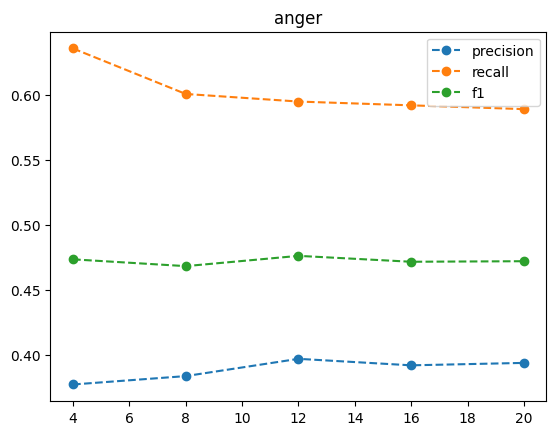

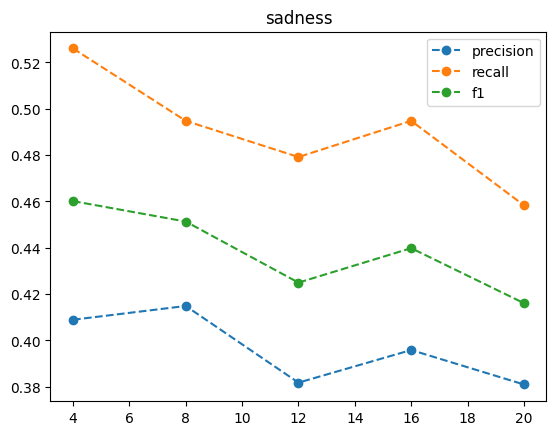

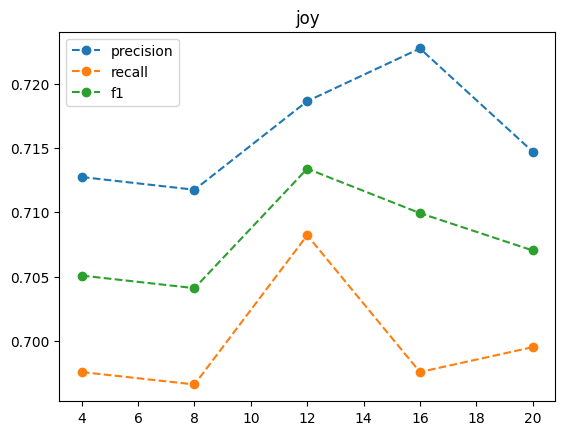

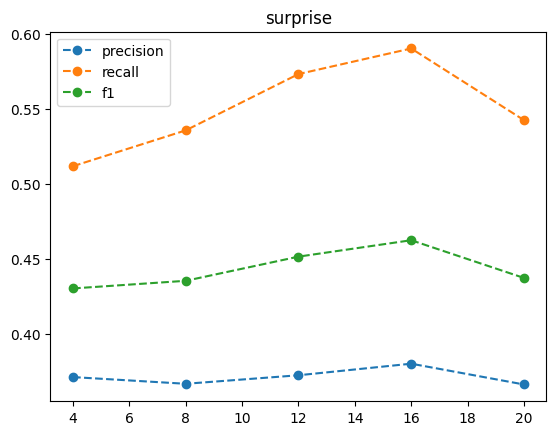

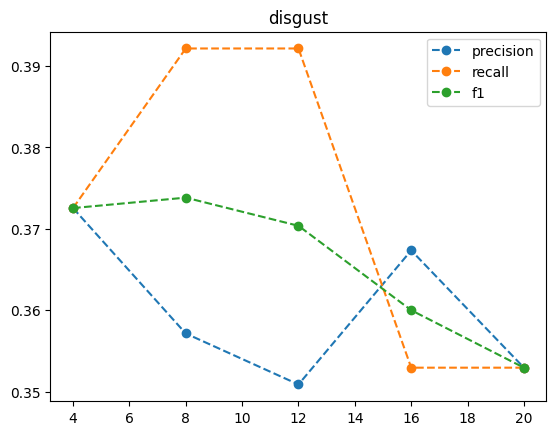

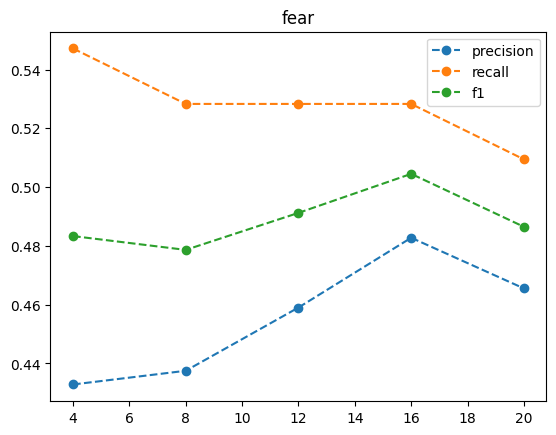

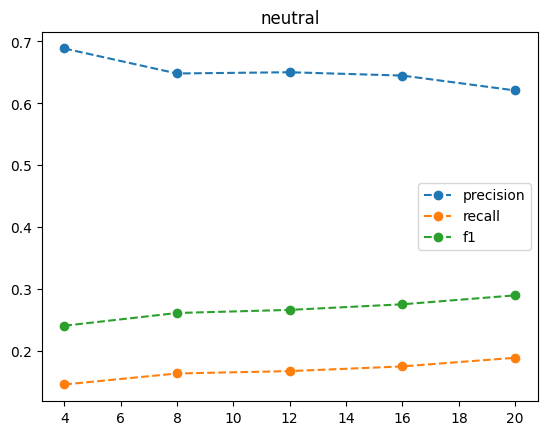

In [41]:
ek = ['anger', 'sadness', 'joy', 'surprise', 'disgust', 'fear', 'neutral']
for j in range(7):
    o = [ek[j]]
    for i in range(len(ek_precision_df.columns)):
        if ek_precision_df.columns[i] in o:
            plt.plot(ek_precision_df.index,ek_precision_df[ek_precision_df.columns[i]],linestyle='--',marker='o', label='precision')
            plt.plot(ek_recall_df.index,ek_recall_df[ek_recall_df.columns[i]],linestyle='--',marker='o', label='recall')
            plt.plot(ek_f1_df.index,ek_f1_df[ek_f1_df.columns[i]],linestyle='--',marker='o', label='f1')
    plt.title(o[0])
    plt.legend(loc='best')
    plt.show()

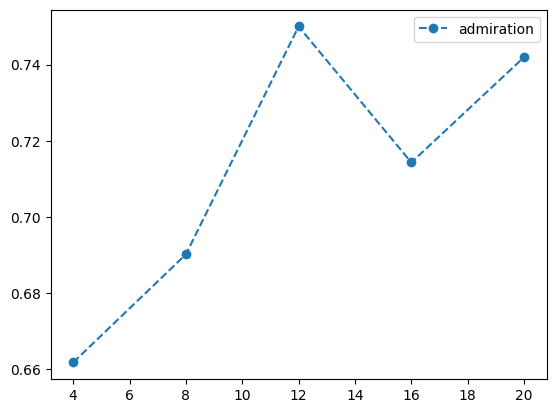

In [32]:
for i in range(len(precision_df.columns)):
    if precision_df.columns[i] in o:
        plt.plot(precision_df.index,precision_df[precision_df.columns[i]],linestyle='--',marker='o', label=precision_df.columns[i])
plt.legend(loc='best')
plt.show()

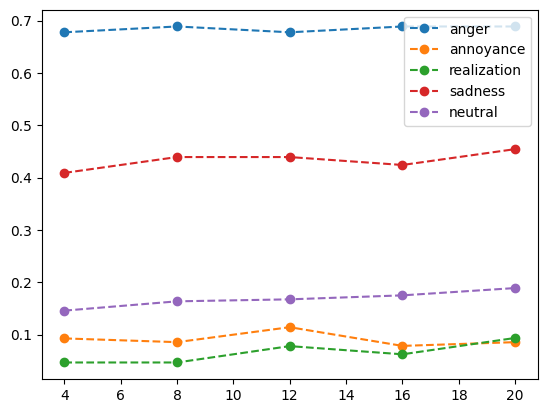

In [255]:
for i in range(len(recall_df.columns)):
    if precision_df.columns[i] in o:
        plt.plot(recall_df.index,recall_df[recall_df.columns[i]],linestyle='--',marker='o', label=recall_df.columns[i])
plt.legend(loc='best')
plt.show()

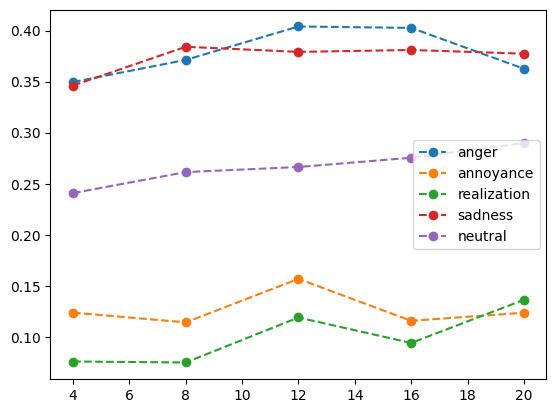

In [256]:
for i in range(len(f1_df.columns)):
    if precision_df.columns[i] in o:
        plt.plot(f1_df.index,f1_df[f1_df.columns[i]],linestyle='--',marker='o', label=f1_df.columns[i])
plt.legend(loc='best')
plt.show()

In [24]:
res = pd.DataFrame(evaluate).transpose()

In [25]:
res.columns = ['accuracy', 'f1_micro', 'f1_macro', 'ekman_accuracy', 'ekman_f1_micro', 'ekman_f1_macro']

In [26]:
res.sort_values('ekman_f1_macro', ascending=False).head()

accuracy  f1_micro  f1_macro  ekman_accuracy  ekman_f1_micro  \
4 1.00 0.25    0.2336  0.306674  0.310768          0.4520        0.510957   
  0.00 0.25    0.2340  0.307335  0.313237          0.4552        0.513205   
  0.25 0.75    0.2300  0.303204  0.306286          0.4540        0.512177   
  0.50 1.00    0.2348  0.307803  0.314658          0.4508        0.506942   
  0.00 0.75    0.2288  0.303734  0.309077          0.4504        0.507865   

             ekman_f1_macro  
4 1.00 0.25        0.451379  
  0.00 0.25        0.448527  
  0.25 0.75        0.448483  
  0.50 1.00        0.447240  
  0.00 0.75        0.446283

In [27]:
res.sort_values('ekman_accuracy', ascending=False).head()

accuracy  f1_micro  f1_macro  ekman_accuracy  ekman_f1_micro  \
20 1.00 0.25    0.2520  0.311410  0.315651          0.4684        0.517105   
   0.00 0.25    0.2500  0.311490  0.318598          0.4652        0.514825   
   0.25 0.75    0.2484  0.309286  0.319521          0.4648        0.514459   
   0.00 0.75    0.2488  0.309593  0.315360          0.4632        0.513043   
   0.50 1.00    0.2468  0.308084  0.314666          0.4628        0.511338   

              ekman_f1_macro  
20 1.00 0.25        0.446220  
   0.00 0.25        0.439698  
   0.25 0.75        0.440783  
   0.00 0.75        0.439340  
   0.50 1.00        0.442157

In [28]:
res.sort_values('f1_macro', ascending=False).head()

accuracy  f1_micro  f1_macro  ekman_accuracy  ekman_f1_micro  \
20 0.25 0.75    0.2484  0.309286  0.319521          0.4648        0.514459   
   0.00 0.25    0.2500  0.311490  0.318598          0.4652        0.514825   
   1.00 0.25    0.2520  0.311410  0.315651          0.4684        0.517105   
   0.00 0.75    0.2488  0.309593  0.315360          0.4632        0.513043   
8  0.00 0.75    0.2380  0.305385  0.314702          0.4556        0.508385   

              ekman_f1_macro  
20 0.25 0.75        0.440783  
   0.00 0.25        0.439698  
   1.00 0.25        0.446220  
   0.00 0.75        0.439340  
8  0.00 0.75        0.441727

In [29]:
res.sort_values('accuracy', ascending=False).head()

accuracy  f1_micro  f1_macro  ekman_accuracy  ekman_f1_micro  \
20 1.00 0.25    0.2520  0.311410  0.315651          0.4684        0.517105   
   0.00 0.25    0.2500  0.311490  0.318598          0.4652        0.514825   
        0.75    0.2488  0.309593  0.315360          0.4632        0.513043   
   0.25 0.75    0.2484  0.309286  0.319521          0.4648        0.514459   
   0.50 1.00    0.2468  0.308084  0.314666          0.4628        0.511338   

              ekman_f1_macro  
20 1.00 0.25        0.446220  
   0.00 0.25        0.439698  
        0.75        0.439340  
   0.25 0.75        0.440783  
   0.50 1.00        0.442157

In [51]:
res.loc[(4,0.25,0.75),:]

accuracy          0.230000
f1_micro          0.303204
f1_macro          0.306286
ekman_accuracy    0.454000
ekman_f1_micro    0.512177
ekman_f1_macro    0.448483
Name: (4, 0.25, 0.75), dtype: float64

In [153]:
import matplotlib.pyplot as plt

In [163]:
res['few'] = [4*i for i in range(1, 6) for _ in range(5)]

In [164]:
res

accuracy  f1_micro  f1_macro  ekman_accuracy  ekman_f1_micro  \
4  0.25 0.75    0.2300  0.303204  0.306286          0.4540        0.512177   
   0.00 0.25    0.2340  0.307335  0.313237          0.4552        0.513205   
   0.50 1.00    0.2348  0.307803  0.314658          0.4508        0.506942   
   0.00 0.75    0.2288  0.303734  0.309077          0.4504        0.507865   
   1.00 0.25    0.2336  0.306674  0.310768          0.4520        0.510957   
8  0.25 0.75    0.2388  0.305109  0.310717          0.4556        0.508755   
   0.00 0.25    0.2360  0.301880  0.313766          0.4552        0.508104   
   0.50 1.00    0.2368  0.303697  0.310342          0.4536        0.505738   
   0.00 0.75    0.2380  0.305385  0.314702          0.4556        0.508385   
   1.00 0.25    0.2356  0.303633  0.313667          0.4560        0.508762   
12 0.25 0.75    0.2460  0.307021  0.309848          0.4580        0.504921   
   0.00 0.25    0.2456  0.306769  0.310329          0.4588        0.505303   
   0.50 1.00    0.2420  0.302490  0.308477          0.4560        0.502556   
   0.00 0.75    0.2456  0.307188  0.312157          0.4592        0.507010   
   1.00 0.25    0.2444  0.305369  0.312458          0.4572        0.503788   
16 0.25 0.75    0.2448  0.306428  0.306900          0.4580        0.504368   
   0.00 0.25    0.2448  0.305500  0.309884          0.4592        0.505223   
   0.50 1.00    0.2420  0.303682  0.304848          0.4564        0.505024   
   0.00 0.75    0.2452  0.306175  0.308255          0.4612        0.507219   
   1.00 0.25    0.2428  0.303363  0.308030          0.4608        0.507123   
20 0.25 0.75    0.2484  0.309286  0.319521          0.4648        0.514459   
   0.00 0.25    0.2500  0.311490  0.318598          0.4652        0.514825   
   0.50 1.00    0.2468  0.308084  0.314666          0.4628        0.511338   
   0.00 0.75    0.2488  0.309593  0.315360          0.4632        0.513043   
   1.00 0.25    0.2520  0.311410  0.315651          0.4684        0.517105   

              ekman_f1_macro  few  
4  0.25 0.75        0.448483    4  
   0.00 0.25        0.448527    4  
   0.50 1.00        0.447240    4  
   0.00 0.75        0.446283    4  
   1.00 0.25        0.451379    4  
8  0.25 0.75        0.443338    8  
   0.00 0.25        0.445704    8  
   0.50 1.00        0.434045    8  
   0.00 0.75        0.441727    8  
   1.00 0.25        0.445630    8  
12 0.25 0.75        0.438242   12  
   0.00 0.25        0.441766   12  
   0.50 1.00        0.437125   12  
   0.00 0.75        0.441717   12  
   1.00 0.25        0.438952   12  
16 0.25 0.75        0.439156   16  
   0.00 0.25        0.438617   16  
   0.50 1.00        0.432778   16  
   0.00 0.75        0.438743   16  
   1.00 0.25        0.437510   16  
20 0.25 0.75        0.440783   20  
   0.00 0.25        0.439698   20  
   0.50 1.00        0.442157   20  
   0.00 0.75        0.439340   20  
   1.00 0.25        0.446220   20

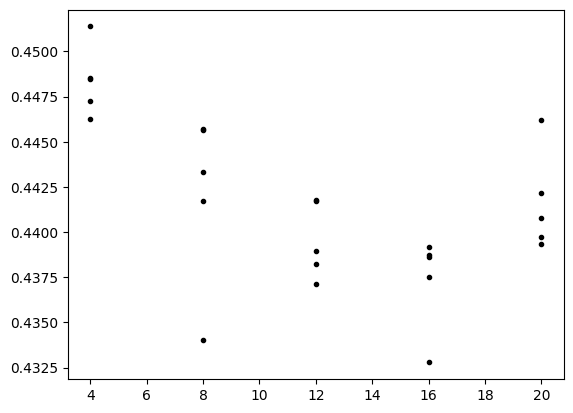

In [165]:
plt.plot(res['few'], res['ekman_f1_macro'], 'k.')

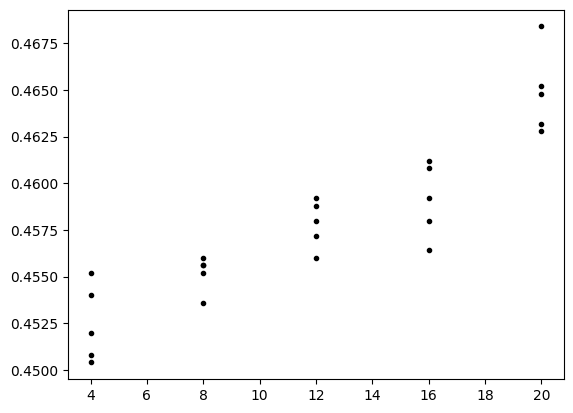

In [166]:
plt.plot(res['few'], res['ekman_accuracy'], 'k.')

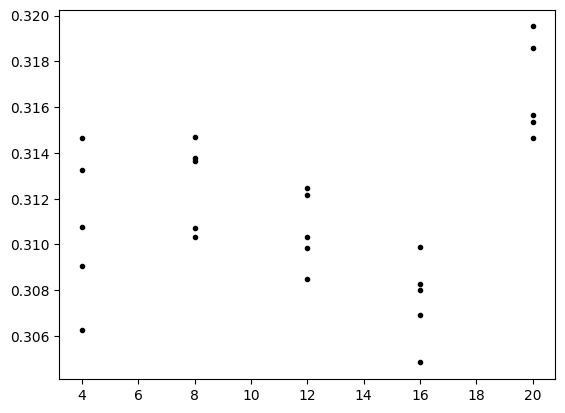

In [167]:
plt.plot(res['few'], res['f1_macro'], 'k.')

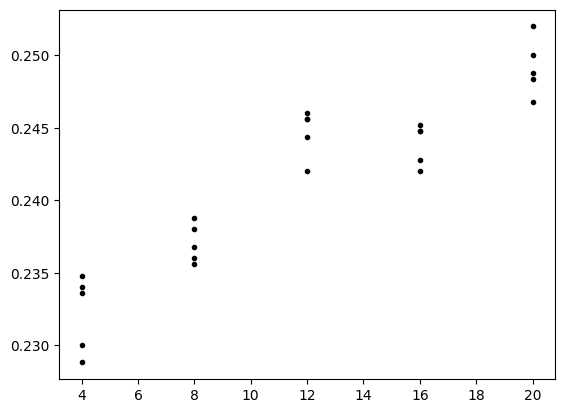

In [168]:
plt.plot(res['few'], res['accuracy'], 'k.')

In [78]:
f4 = '''{\"example_id\": 0, \"input\": \"I love Rocket Love and Blasted. I just wonder who the songs were written for because these are all reference tracks except Acura Intergul\", \"output\": {\"analysis\": [{\"emotion\": \"love\", \"reason\": \"The text expresses love.\"}]}}\n{\"example_id\": 1, \"input\": \"good luck buddy\", \"output\": {\"analysis\": [{\"emotion\": \"optimism\", \"reason\": \"The text expresses optimism.\"}]}}\n{\"example_id\": 2, \"input\": \"Eat too many whoppers and he'll be down with the sickness. Lma0 I'm sorry\", \"output\": {\"analysis\": [{\"emotion\": \"remorse\", \"reason\": \"The text expresses remorse.\"}]}}\n{\"example_id\": 3, \"input\": \"Awesome photo, love the bricks in the background and the color suits you chose. Very nice gents! \", \"output\": {\"analysis\": [{\"emotion\": \"admiration\", \"reason\": \"The text praises the aesthetic and compliments the people involved.\"}, {\"emotion\": \"approval\", \"reason\": \"The speaker expresses positive evaluation and encouragement.\"}]}}'''.split('\n')
f8 = '''{\"example_id\": 0, \"input\": \"I love Rocket Love and Blasted. I just wonder who the songs were written for because these are all reference tracks except Acura Intergul\", \"output\": {\"analysis\": [{\"emotion\": \"love\", \"reason\": \"The text expresses love.\"}]}}\n{\"example_id\": 1, \"input\": \"good luck buddy\", \"output\": {\"analysis\": [{\"emotion\": \"optimism\", \"reason\": \"The text expresses optimism.\"}]}}\n{\"example_id\": 2, \"input\": \"sorry [NAME]! \\ud83d\\ude18\\ud83d\\ude18\\ud83d\\ude18\", \"output\": {\"analysis\": [{\"emotion\": \"sadness\", \"reason\": \"The text expresses sadness.\"}]}}\n{\"example_id\": 3, \"input\": \"Eat too many whoppers and he'll be down with the sickness. Lma0 I'm sorry\", \"output\": {\"analysis\": [{\"emotion\": \"remorse\", \"reason\": \"The text expresses remorse.\"}]}}\n{\"example_id\": 4, \"input\": \"It's true though. He either gets no shirt and freezes to death or wears a stupid looking butchers cape. I hope he gets something better next season\", \"output\": {\"analysis\": [{\"emotion\": \"optimism\", \"reason\": \"The text expresses optimism.\"}]}}\n{\"example_id\": 5, \"input\": \"You can always kneel.\", \"output\": {\"analysis\": [{\"emotion\": \"approval\", \"reason\": \"The text expresses approval.\"}]}}\n{\"example_id\": 6, \"input\": \"I don't think aspergers causes me distress or anxiety. I think having to live in a society that privileges neurotypical modes of interaction causes me distress and anxiety\", \"output\": {\"analysis\": [{\"emotion\": \"realization\", \"reason\": \"The text expresses realization.\"}]}}\n{\"example_id\": 7, \"input\": \"Awesome photo, love the bricks in the background and the color suits you chose. Very nice gents! \", \"output\": {\"analysis\": [{\"emotion\": \"admiration\", \"reason\": \"The text praises the aesthetic and compliments the people involved.\"}, {\"emotion\": \"approval\", \"reason\": \"The speaker expresses positive evaluation and encouragement.\"}]}}'''.split('\n')
f12 = '''{\"example_id\": 0, \"input\": \"I love Rocket Love and Blasted. I just wonder who the songs were written for because these are all reference tracks except Acura Intergul\", \"output\": {\"analysis\": [{\"emotion\": \"love\", \"reason\": \"The text expresses love.\"}]}}\n{\"example_id\": 1, \"input\": \"It's true though. He either gets no shirt and freezes to death or wears a stupid looking butchers cape. I hope he gets something better next season\", \"output\": {\"analysis\": [{\"emotion\": \"optimism\", \"reason\": \"The text expresses optimism.\"}]}}\n{\"example_id\": 2, \"input\": \"good luck buddy\", \"output\": {\"analysis\": [{\"emotion\": \"optimism\", \"reason\": \"The text expresses optimism.\"}]}}\n{\"example_id\": 3, \"input\": \"Eat too many whoppers and he'll be down with the sickness. Lma0 I'm sorry\", \"output\": {\"analysis\": [{\"emotion\": \"remorse\", \"reason\": \"The text expresses remorse.\"}]}}\n{\"example_id\": 4, \"input\": \"I don't think aspergers causes me distress or anxiety. I think having to live in a society that privileges neurotypical modes of interaction causes me distress and anxiety\", \"output\": {\"analysis\": [{\"emotion\": \"realization\", \"reason\": \"The text expresses realization.\"}]}}\n{\"example_id\": 5, \"input\": \"[NAME]\", \"output\": {\"analysis\": [{\"emotion\": \"disgust\", \"reason\": \"The text expresses disgust.\"}]}}\n{\"example_id\": 6, \"input\": \"i got a bump and a bald spot. i feel dumb <3\", \"output\": {\"analysis\": [{\"emotion\": \"embarrassment\", \"reason\": \"The text expresses embarrassment.\"}]}}\n{\"example_id\": 7, \"input\": \"Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait \\ud83d\\ude1d\", \"output\": {\"analysis\": [{\"emotion\": \"gratitude\", \"reason\": \"The text expresses gratitude.\"}]}}\n{\"example_id\": 8, \"input\": \"sorry [NAME]! \\ud83d\\ude18\\ud83d\\ude18\\ud83d\\ude18\", \"output\": {\"analysis\": [{\"emotion\": \"sadness\", \"reason\": \"The text expresses sadness.\"}]}}\n{\"example_id\": 9, \"input\": \"You can always kneel.\", \"output\": {\"analysis\": [{\"emotion\": \"approval\", \"reason\": \"The text expresses approval.\"}]}}\n{\"example_id\": 10, \"input\": \"Awesome photo, love the bricks in the background and the color suits you chose. Very nice gents! \", \"output\": {\"analysis\": [{\"emotion\": \"admiration\", \"reason\": \"The text praises the aesthetic and compliments the people involved.\"}, {\"emotion\": \"approval\", \"reason\": \"The speaker expresses positive evaluation and encouragement.\"}]}}\n{\"example_id\": 11, \"input\": \"She said that? Wtf?? That's fucked up. I shouldn't be surprised. Hypocrisy is common with this bunch.\", \"output\": {\"analysis\": [{\"emotion\": \"anger\", \"reason\": \"The speaker reacts with strong outrage and frustration toward someone's behavior.\"}, {\"emotion\": \"annoyance\", \"reason\": \"The tone shows irritation and exasperation at hypocrisy.\"}]}}'''.split('\n')
f16 = '''{\"example_id\": 0, \"input\": \"Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait \\ud83d\\ude1d\", \"output\": {\"analysis\": [{\"emotion\": \"gratitude\", \"reason\": \"The text expresses gratitude.\"}]}}\n{\"example_id\": 1, \"input\": \"Eat too many whoppers and he'll be down with the sickness. Lma0 I'm sorry\", \"output\": {\"analysis\": [{\"emotion\": \"remorse\", \"reason\": \"The text expresses remorse.\"}]}}\n{\"example_id\": 2, \"input\": \"good luck buddy\", \"output\": {\"analysis\": [{\"emotion\": \"optimism\", \"reason\": \"The text expresses optimism.\"}]}}\n{\"example_id\": 3, \"input\": \"I don't think aspergers causes me distress or anxiety. I think having to live in a society that privileges neurotypical modes of interaction causes me distress and anxiety\", \"output\": {\"analysis\": [{\"emotion\": \"realization\", \"reason\": \"The text expresses realization.\"}]}}\n{\"example_id\": 4, \"input\": \"sorry [NAME]! \\ud83d\\ude18\\ud83d\\ude18\\ud83d\\ude18\", \"output\": {\"analysis\": [{\"emotion\": \"sadness\", \"reason\": \"The text expresses sadness.\"}]}}\n{\"example_id\": 5, \"input\": \"I love Rocket Love and Blasted. I just wonder who the songs were written for because these are all reference tracks except Acura Intergul\", \"output\": {\"analysis\": [{\"emotion\": \"love\", \"reason\": \"The text expresses love.\"}]}}\n{\"example_id\": 6, \"input\": \"i got a bump and a bald spot. i feel dumb <3\", \"output\": {\"analysis\": [{\"emotion\": \"embarrassment\", \"reason\": \"The text expresses embarrassment.\"}]}}\n{\"example_id\": 7, \"input\": \"I want to go back in time and hug you as a child (after you got the lice treated tho).\", \"output\": {\"analysis\": [{\"emotion\": \"desire\", \"reason\": \"The text expresses desire.\"}]}}\n{\"example_id\": 8, \"input\": \"Apologies, I take it all back as I\\u2019ve just seen his latest effort\", \"output\": {\"analysis\": [{\"emotion\": \"remorse\", \"reason\": \"The text expresses remorse.\"}]}}\n{\"example_id\": 9, \"input\": \"I think the 90 day rule applies to increases over 5%?\", \"output\": {\"analysis\": [{\"emotion\": \"curiosity\", \"reason\": \"The text expresses curiosity.\"}]}}\n{\"example_id\": 10, \"input\": \"true I am a troll, but fortunately for me I'm not emotionally invested in it.\", \"output\": {\"analysis\": [{\"emotion\": \"approval\", \"reason\": \"The text expresses approval.\"}]}}\n{\"example_id\": 11, \"input\": \"You can always kneel.\", \"output\": {\"analysis\": [{\"emotion\": \"approval\", \"reason\": \"The text expresses approval.\"}]}}\n{\"example_id\": 12, \"input\": \"[NAME]\", \"output\": {\"analysis\": [{\"emotion\": \"disgust\", \"reason\": \"The text expresses disgust.\"}]}}\n{\"example_id\": 13, \"input\": \"It's true though. He either gets no shirt and freezes to death or wears a stupid looking butchers cape. I hope he gets something better next season\", \"output\": {\"analysis\": [{\"emotion\": \"optimism\", \"reason\": \"The text expresses optimism.\"}]}}\n{\"example_id\": 14, \"input\": \"She said that? Wtf?? That's fucked up. I shouldn't be surprised. Hypocrisy is common with this bunch.\", \"output\": {\"analysis\": [{\"emotion\": \"anger\", \"reason\": \"The speaker reacts with strong outrage and frustration toward someone's behavior.\"}, {\"emotion\": \"annoyance\", \"reason\": \"The tone shows irritation and exasperation at hypocrisy.\"}]}}\n{\"example_id\": 15, \"input\": \"Awesome photo, love the bricks in the background and the color suits you chose. Very nice gents! \", \"output\": {\"analysis\": [{\"emotion\": \"admiration\", \"reason\": \"The text praises the aesthetic and compliments the people involved.\"}, {\"emotion\": \"approval\", \"reason\": \"The speaker expresses positive evaluation and encouragement.\"}]}}'''.split('\n')
f20 = '''{\"example_id\": 0, \"input\": \"I don't think aspergers causes me distress or anxiety. I think having to live in a society that privileges neurotypical modes of interaction causes me distress and anxiety\", \"output\": {\"analysis\": [{\"emotion\": \"realization\", \"reason\": \"The text expresses realization.\"}]}}\n{\"example_id\": 1, \"input\": \"Apologies, I take it all back as I\\u2019ve just seen his latest effort\", \"output\": {\"analysis\": [{\"emotion\": \"remorse\", \"reason\": \"The text expresses remorse.\"}]}}\n{\"example_id\": 2, \"input\": \"Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait \\ud83d\\ude1d\", \"output\": {\"analysis\": [{\"emotion\": \"gratitude\", \"reason\": \"The text expresses gratitude.\"}]}}\n{\"example_id\": 3, \"input\": \"i got a bump and a bald spot. i feel dumb <3\", \"output\": {\"analysis\": [{\"emotion\": \"embarrassment\", \"reason\": \"The text expresses embarrassment.\"}]}}\n{\"example_id\": 4, \"input\": \"It's true though. He either gets no shirt and freezes to death or wears a stupid looking butchers cape. I hope he gets something better next season\", \"output\": {\"analysis\": [{\"emotion\": \"optimism\", \"reason\": \"The text expresses optimism.\"}]}}\n{\"example_id\": 5, \"input\": \"I want to go back in time and hug you as a child (after you got the lice treated tho).\", \"output\": {\"analysis\": [{\"emotion\": \"desire\", \"reason\": \"The text expresses desire.\"}]}}\n{\"example_id\": 6, \"input\": \"I love Rocket Love and Blasted. I just wonder who the songs were written for because these are all reference tracks except Acura Intergul\", \"output\": {\"analysis\": [{\"emotion\": \"love\", \"reason\": \"The text expresses love.\"}]}}\n{\"example_id\": 7, \"input\": \"true I am a troll, but fortunately for me I'm not emotionally invested in it.\", \"output\": {\"analysis\": [{\"emotion\": \"approval\", \"reason\": \"The text expresses approval.\"}]}}\n{\"example_id\": 8, \"input\": \"Eat too many whoppers and he'll be down with the sickness. Lma0 I'm sorry\", \"output\": {\"analysis\": [{\"emotion\": \"remorse\", \"reason\": \"The text expresses remorse.\"}]}}\n{\"example_id\": 9, \"input\": \"Thats insane. Someone died like 2 years ago after a bolt got kicked up by a truck and went through his windshield and hit him on 146 in LaPorte\", \"output\": {\"analysis\": [{\"emotion\": \"grief\", \"reason\": \"The text expresses grief.\"}]}}\n{\"example_id\": 10, \"input\": \"Glad you feel better! My offer still stands though, if you need someone, I\\u2019m here\", \"output\": {\"analysis\": [{\"emotion\": \"relief\", \"reason\": \"The text expresses relief.\"}]}}\n{\"example_id\": 11, \"input\": \"good luck buddy\", \"output\": {\"analysis\": [{\"emotion\": \"optimism\", \"reason\": \"The text expresses optimism.\"}]}}\n{\"example_id\": 12, \"input\": \"[NAME]\", \"output\": {\"analysis\": [{\"emotion\": \"disgust\", \"reason\": \"The text expresses disgust.\"}]}}\n{\"example_id\": 13, \"input\": \"You can always kneel.\", \"output\": {\"analysis\": [{\"emotion\": \"approval\", \"reason\": \"The text expresses approval.\"}]}}\n{\"example_id\": 14, \"input\": \"I think the 90 day rule applies to increases over 5%?\", \"output\": {\"analysis\": [{\"emotion\": \"curiosity\", \"reason\": \"The text expresses curiosity.\"}]}}\n{\"example_id\": 15, \"input\": \"No one comes here it\\u2019s cool\", \"output\": {\"analysis\": [{\"emotion\": \"relief\", \"reason\": \"The text expresses relief.\"}]}}\n{\"example_id\": 16, \"input\": \"sorry [NAME]! \\ud83d\\ude18\\ud83d\\ude18\\ud83d\\ude18\", \"output\": {\"analysis\": [{\"emotion\": \"sadness\", \"reason\": \"The text expresses sadness.\"}]}}\n{\"example_id\": 17, \"input\": \"She said that? Wtf?? That's fucked up. I shouldn't be surprised. Hypocrisy is common with this bunch.\", \"output\": {\"analysis\": [{\"emotion\": \"anger\", \"reason\": \"The speaker reacts with strong outrage and frustration toward someone's behavior.\"}, {\"emotion\": \"annoyance\", \"reason\": \"The tone shows irritation and exasperation at hypocrisy.\"}]}}\n{\"example_id\": 18, \"input\": \"Awesome photo, love the bricks in the background and the color suits you chose. Very nice gents! \", \"output\": {\"analysis\": [{\"emotion\": \"admiration\", \"reason\": \"The text praises the aesthetic and compliments the people involved.\"}, {\"emotion\": \"approval\", \"reason\": \"The speaker expresses positive evaluation and encouragement.\"}]}}\n{\"example_id\": 19, \"input\": \"Now I guess the question is, were they dipping their brush in their own paint pot, or were they sharing with a friend ?\", \"output\": {\"analysis\": [{\"emotion\": \"confusion\", \"reason\": \"The rhetorical phrasing shows uncertainty and lack of clarity about the situation.\"}, {\"emotion\": \"curiosity\", \"reason\": \"The question implies genuine interest or intrigue about what actually happened.\"}]}}'''.split('\n')

In [ ]:
for i in f20:
    t = json.loads(i)
    for j in t['output']['analysis']:
        print(j['emotion'], end=' ')
    print()

realization 
remorse 
gratitude 
embarrassment 
optimism 
desire 
love 
approval 
remorse 
grief 
relief 
optimism 
disgust 
approval 
curiosity 
relief 
sadness 
anger annoyance 
admiration approval 
confusion curiosity 


In [96]:
print(f20)

['{"example_id": 0, "input": "I don\'t think aspergers causes me distress or anxiety. I think having to live in a society that privileges neurotypical modes of interaction causes me distress and anxiety", "output": {"analysis": [{"emotion": "realization", "reason": "The text expresses realization."}]}}', '{"example_id": 1, "input": "Apologies, I take it all back as I\\u2019ve just seen his latest effort", "output": {"analysis": [{"emotion": "remorse", "reason": "The text expresses remorse."}]}}', '{"example_id": 2, "input": "Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait \\ud83d\\ude1d", "output": {"analysis": [{"emotion": "gratitude", "reason": "The text expresses gratitude."}]}}', '{"example_id": 3, "input": "i got a bump and a bald spot. i feel dumb <3", "output": {"analysis": [{"emotion": "embarrassment", "reason": "The text expresses embarrassment."}]}}', '{"example_id": 4, "input": "It\'s true though. He either 

In [128]:
cnts = [0] * len(ems.split())
tmp_df = data.drop(columns='text')
for i in range(len(ems.split())):
    # print(tmp_df.iloc[:,i])
    for j in tmp_df.iloc[:,i]:
        if j == 1:
            cnts[i] += 1
    

In [147]:
cnts

[228,
 148,
 90,
 140,
 173,
 65,
 68,
 115,
 34,
 79,
 139,
 51,
 15,
 41,
 43,
 166,
 9,
 93,
 108,
 11,
 105,
 10,
 64,
 7,
 38,
 66,
 61,
 788]

In [158]:
asdf = pd.DataFrame(data=cnts[:27], index=ems.split()[:27])

In [159]:
asdfg = asdf.sort_values(0, ascending=False)

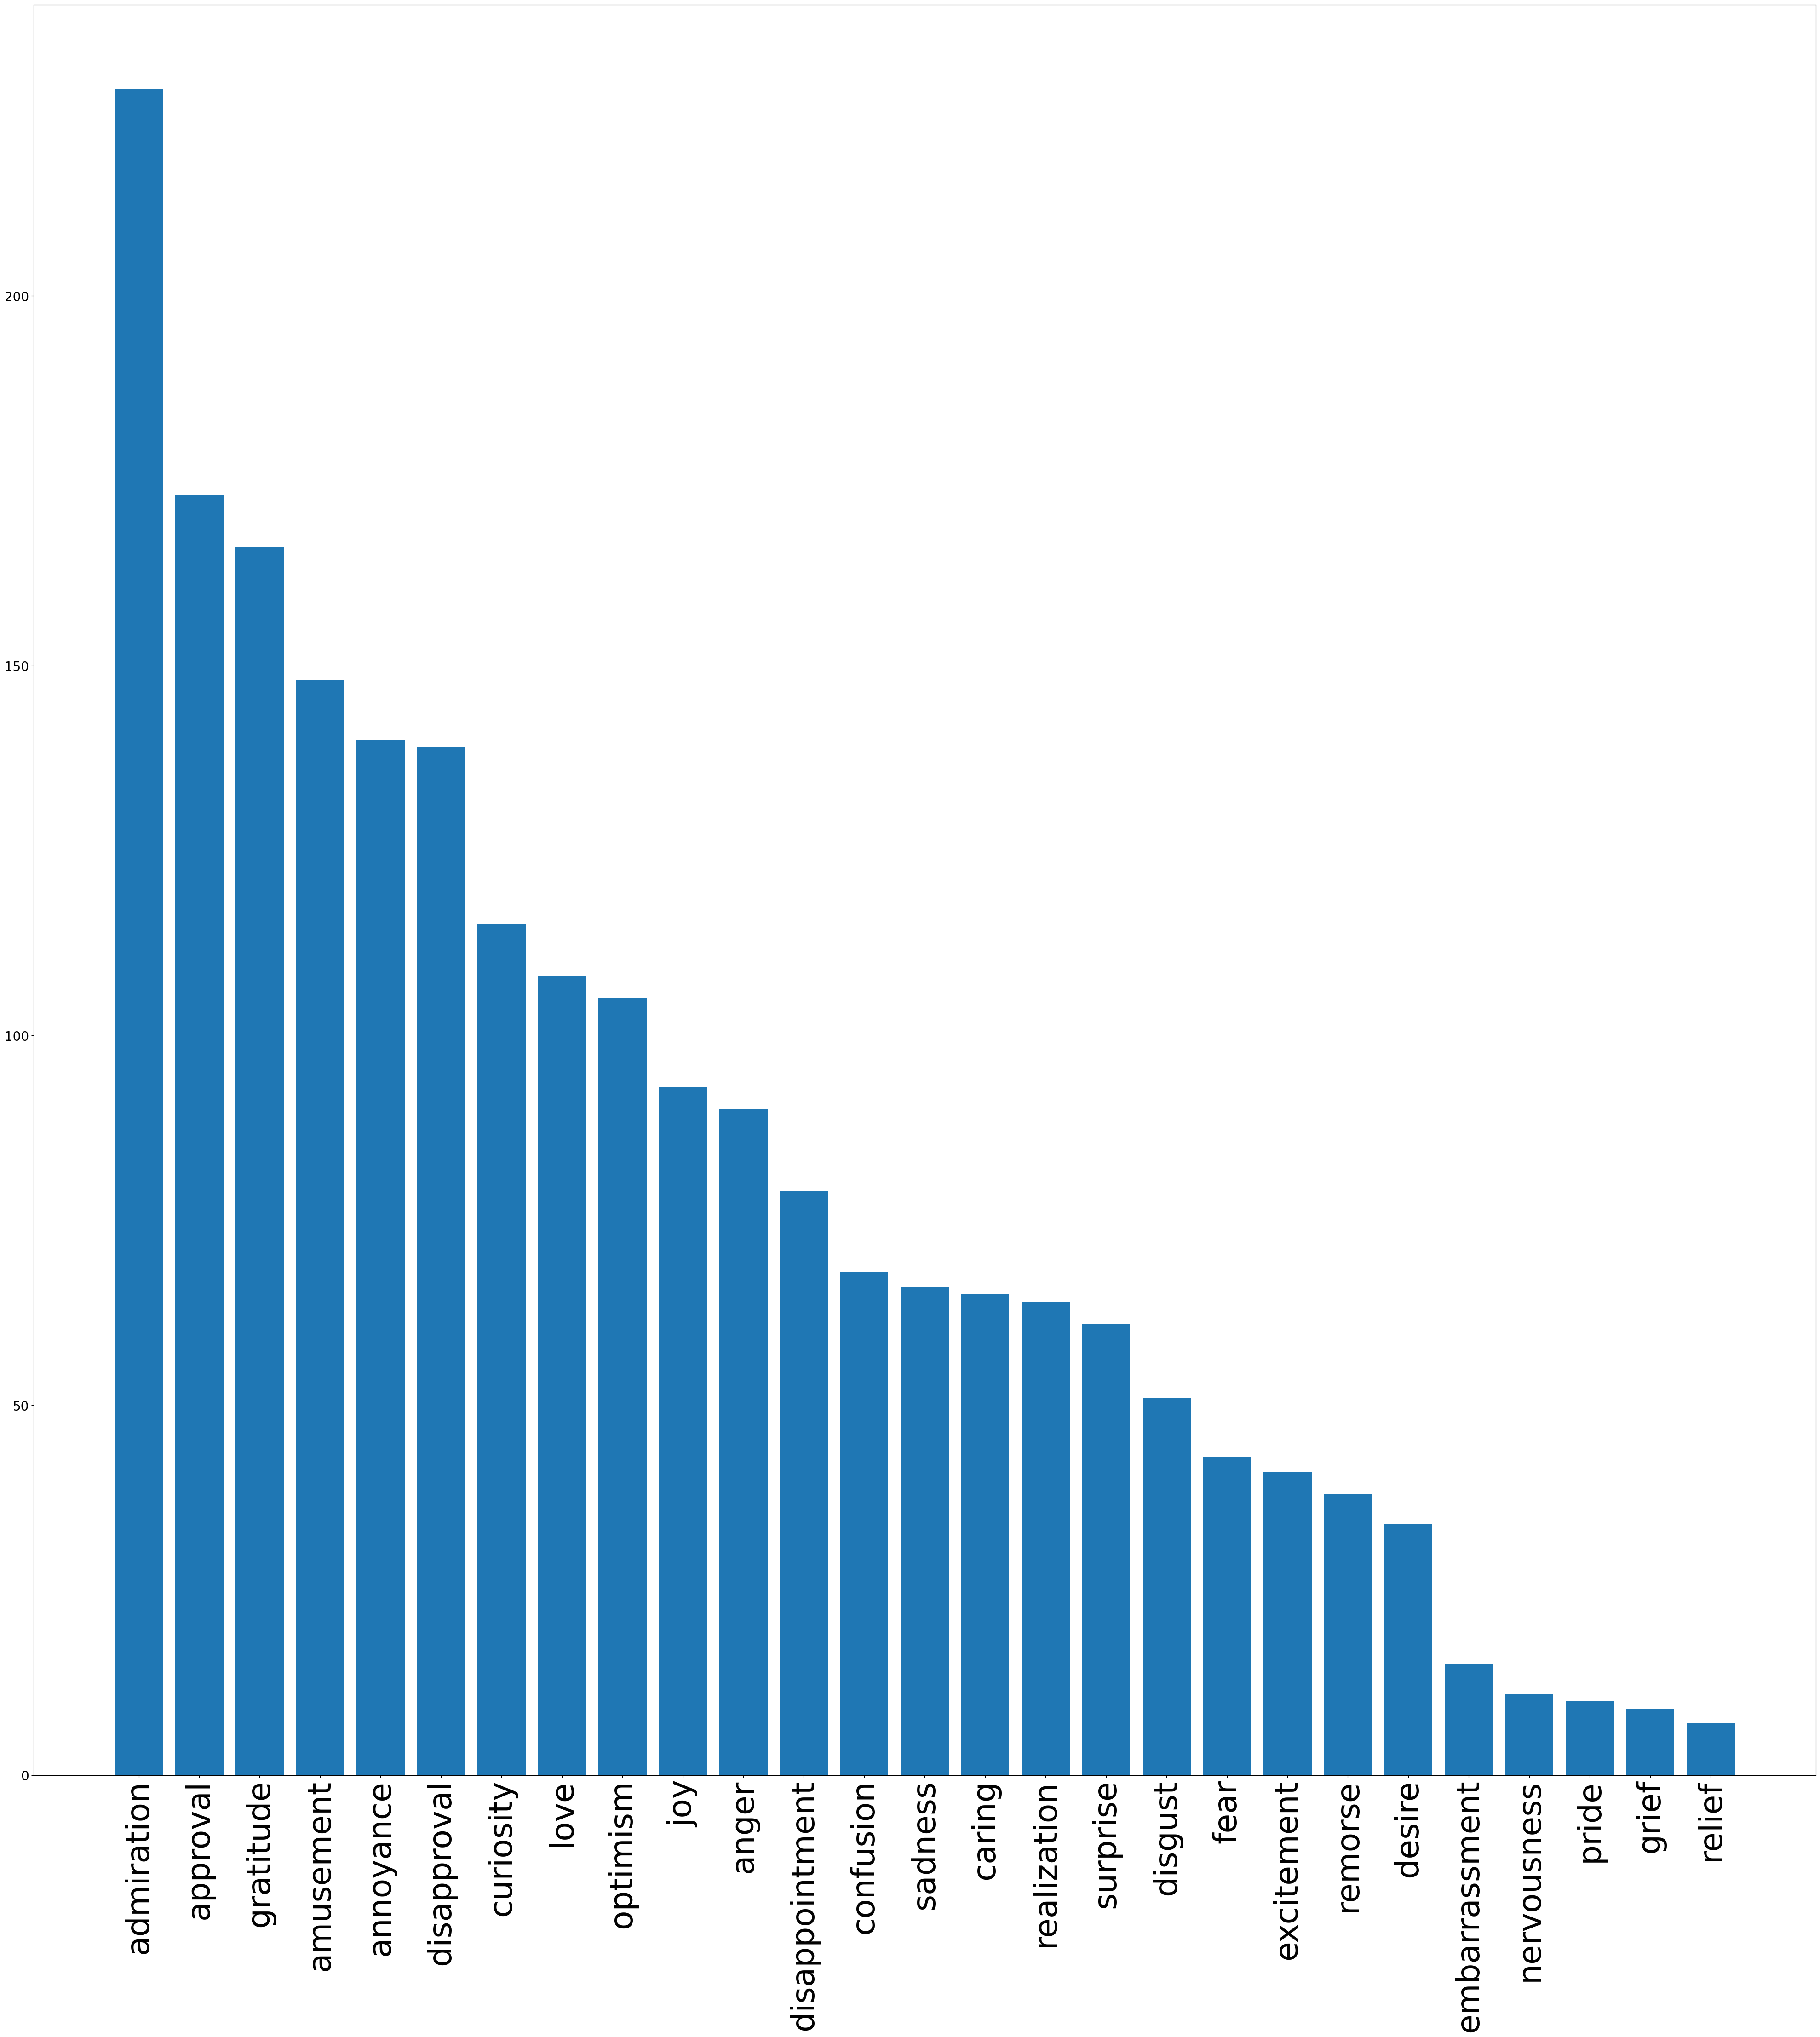

In [160]:
plt.figure(figsize=(50, 50))
plt.xticks(rotation=90)
plt.rc('font', size=10)

plt.bar(asdfg.index, asdfg[0])
plt.show()

In [2]:
ek_res = pd.read_csv('./output/20251028/ek_f1.csv')

,Unnamed: 0,anger,disgust,fear,joy,sadness,surprise,neutral
0,4,0.473398,0.372549,0.483333,0.705078,0.460137,0.430416,0.240838
1,8,0.468182,0.373832,0.478632,0.704102,0.451306,0.435506,0.261398
2,12,0.476079,0.370370,0.491228,0.713382,0.424942,0.451613,0.266398
3,16,0.471545,0.360000,0.504505,0.709931,0.439815,0.462567,0.275449
4,20,0.471963,0.352941,0.486486,0.707031,0.416076,0.437414,0.289883
